# Train Finder

This object takes a collection of frames. The frame names are indexed in lexicographic order in a JSON. 
The output characterizes the images with mixture models, color patches, and metadata about frames and breaks. 

## Image Utilities

In [252]:
'''This library contains image utilities which are of general use for multiple objects.'''

'''This function converts frames from bgr to Lab, which is more useful for clustering'''
# This converts image arrays to Lab space
def convert2LAB(frame_list):
    no_frames = len(frame_list)
    lab_list = ['']*no_frames
        
    for i in range(no_frames):
        img = frame_list[i]
        conv= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        lab_list[i]=conv 
        
    return lab_list

# requires an actual list of frames
# If you sample from one frame, wrap it in a list
'''This is an eyedropper function. Provide a frame list, desired sample, and desired location. The function returns a list of pixels in array format.'''
def random_pixel_sample(frame_list,num_sample,c,r_min,r_max):
    l = len(frame_list)
    sampled_pixels = []
    
    for i in range(num_sample):
        ll = np.random.randint(l)
        if (r_min==r_max):
            rr = r_max
        else:
            rr = np.random.randint(r_min,r_max)
        cc = np.random.randint(c)
        randcolor = frame_list[ll][rr,cc,:]
        sampled_pixels.append(randcolor)
        
    return sampled_pixels  

'''This function converts from L*a*b color space to rgb. This makes the list of pixels more consumable by other libraries.'''
# Takes a list of pixels in lab, 
# returns a list of pixels in rgb
def lab2rgb(color_list):
    n = len(color_list)
    rgb_list = []*n
    for i in range(n):
        L,a,b = color_list[i]
        L_ = L*(100/255)
        a_ = a-128
        b_ = b-128
        lab_color = np.array([[[L_,a_,b_]]])
        rgb_conv = color.lab2rgb(lab_color)
        r, g, b = rgb_conv[0,0,0:3]
        rgb_list.append((r,g,b))
    
    return rgb_list

import pylab

# draws exactly five patches and outputs to screen
def draw_patches(rgb_color_list,save_to_file=False,file_info=None):
    
    file_loc, metadata, filename = file_info
    fig = plt.figure()
    ax = fig.add_subplot(111)     

    rect1 = matplotlib.patches.Rectangle((0,  0), 100, 100, color=rgb_color_list[0])
    rect2 = matplotlib.patches.Rectangle((150, 0), 100, 100, color=rgb_color_list[1])
    rect3 = matplotlib.patches.Rectangle((300, 0), 100, 100, color=rgb_color_list[2])
    rect4 = matplotlib.patches.Rectangle((0,-150), 100, 100, color=rgb_color_list[3])
    rect5 = matplotlib.patches.Rectangle((150,-150), 100, 100, color=rgb_color_list[4])
    
    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    
    plt.xlim([-50, 450])
    plt.ylim([-200, 150])
    plt.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        left='off',
        labelbottom='off',
        labelleft='off') # labels along the bottom edge are off
    
    if (save_to_file):
        pylab.savefig(file_name)
    else:
        plt.show()

## Model Controller

In [173]:
import json, cv2, random, pylab, os, math
import numpy as np

from skimage import io, color
from sklearn.externals import joblib
from sklearn.mixture import GaussianMixture

'''Train finding functionality is provided with three separate objects. This helps to enhance readability.

The first of these objects is the Finder_Controller, which acquires needed frame data. The object initializes and manipulates the Finder_Mode..er
'''
class Finder_Controller():
    
    input_file = ''
    output_dir = ''
    directory = ''
    frame_names = []
    frame_list = []

    no_frames = 0
    Model = None
    model_spec = ''
    
    # Output file is the name of a metadata directory
    # This is parsed to find the input directory
    # This reads an JSON which is a list of frames in the input directory
    '''The initialization sequences all necessary tasks.'''
    def __init__(self, output_dir):
        
        self.output_dir=output_dir
        self.make_metadata_directory()
        self.get_home()
        self.process_input()        
        self.get_frame_list()
        self.make_model()

    '''This function makes a directory to store the metadata, if it is not already present.'''
    def make_metadata_directory(self):
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)
            
    '''This gets the home directory given the information provided in the initialization.'''
    def get_home(self):
        directory_list = self.output_dir.split("/")
        parts = len(directory_list)
        self.directory = "/".join(directory_list[0:parts-1])
        self.input_file = self.directory+"/"+'image_list.json'   

    '''This opens the json file which contains a list of all image files for loading.'''
    def process_input(self):
        with open(self.input_file) as json_file:
            # this is a list of file names in order
            self.frame_names = json.load(json_file)
        self.no_frames = len(self.frame_names) 
 
    '''This creates a list of frames. A frame is an array of pixels. The pixels are stored in openCV bgr format.'''
    def get_frame_list(self):
        for i in range(self.no_frames):
            if (i%100==0):
                print("TRAIN FINDER, Get Frame List,"+str(i))
            name = self.frame_names[i]
            full_name = self.directory+"/"+name
            image = cv2.imread(full_name)
            self.frame_list.append(image) 
        print("TRAIN FINDER, Loaded "+str(self.no_frames))
    
    '''This creates the Finder_Modeller. In principle the modeller could be further customized during initialization. The current presets seem to work well.'''
    def make_model(self):
        self.Model = Finder_Modeller_Stub(self.frame_list,self.output_dir)
    

In [174]:
class Finder_Modeller_Stub():
    data = None
    model_spec = None
    
    def __init__(self,frame_list,spec):
        print("FINDER MODELLER, Init")
        self.data = frame_list
        self.model_spec = spec


In [228]:
import ImageProcessingUtilities
# This class fits the models and allows access to outputs
# It does not manage the post-processing 
'''This class develops models to characterize the trains and background from provided image data.

The object is instantiated from the Finder_Controller. It in turn instatiates a Finder_Viewer which performs further post-processing.
'''
class Finder_Modeller():
    
    lab_list = None
    metadata = ''
    Viewer = None
    log_odds = None
    train_list = []
    background_list = []
    breaks = []
    
    '''The model performs an Expectation Maximization algorithm to iteratively identify frame types and appropriate characterizations.'''
    def __init__(self, frame_list, metadata, init=3):
        self.metadata=metadata
        print("FINDER MODELLER, Converting to LAB")
        lab_list = convert2LAB(frame_list)
        # step 1 initialize, specify the frames to sample
        print("FINDER MODELLER, Init")
        train_list, background_list = self.train_finder_init(lab_list)
        for i in range(init):
            print("FINDER MODELLER, Iteration "+str(i))
            # step E1 sample pixels from frames
            print("FINDER MODELLER, Expectation")
            train_sample, background_sample, priors = self.train_sampler(train_list,background_list)
        
            # step E2 perform the gmm          
            (colors, models) = self.train_finder_gmm(train_sample,background_sample)
            print("FINDER MODELLER, Maximization")
            # step M1 classify the frames
            classifier, self.log_odds = self.classify_frames(models,priors,frame_list)
            # step M2 collect new samples 
            self.train_list, self.background_list, self.breaks = self.new_samples(train_list,classifier)
        
        print("FINDER MODELLER, Output")
        # step 2A -- output models        
        self.serialize_models(models)
        # step 3A -- create a Viewer object to deliver useful graphics      
        self.Viewer = Model_Viewer_Stub(colors=colors,classifier=classifier,breaks=self.breaks,metadata=self.metadata)
        
    '''The model starts with simple assumptions. The train starts at one-third through the video and continues to the end.
    
    The model appears very robust. Initial assumptions dont matter much.'''
    def train_finder_init(self,frame_list):
        l=len(frame_list)
        third = int(l/3)
        last = l 
        train_list =frame_list[0:third]
        background_list = frame_list[third:last]
    
        return train_list, background_list

    '''This creates a list of pixels sampled from the putative train and background frames. This is part one of the expectation algorithm, and it requires two lists of frames according to categories.
    
    Priors are used to empirically fine tune the algorithm at a later step. '''
    def train_sampler(self,train_list, background_list, sample=10000):
        r, c, p = frame_list[0].shape
        background_sample=random_pixel_sample(train_list,sample,c,0,r)
        train_sample=random_pixel_sample(background_list,sample,c,0,r)
        t = len(train_list)
        b = len(background_list)  
        train_prior = t/(t+b)
        background_prior = b/(b+t)
        priors = (train_prior, background_prior)
    
        return train_sample, background_sample, priors

    '''This is part two of the expectation procedure. The model characterizes the train and background using a 3-D kernel distribution of pixels.
    
    The model uses scikitlearn GaussianMixture model which is itself also an EM algorithm.'''
    def train_finder_gmm(self,train_sample,background_sample,n=5):
        background_gmm = GaussianMixture(n_components=n,covariance_type='full').fit(background_sample)
        background_colors = lab2rgb(background_gmm.means_)
        train_gmm = GaussianMixture(n_components=n,covariance_type='full').fit(train_sample)
        train_colors = lab2rgb(train_gmm.means_)    
        colors = (train_colors,background_colors)
        models = (train_gmm, background_gmm)
    
        return colors, models

    '''This uses the models to classify each frame by type. This is the first stage of the maxization procedure. 
    
    It returns the log-odds of each frame being a train, with higher odds indicating a higher likelihood of a train. '''
    def classify_frames(self,models,priors,frame_list):
        (train_gmm, background_gmm) = models
        (train_prior,background_prior) = priors
        x = len(frame_list)
        r, c, p = frame_list[0].shape
        track=[0]*x
        background=[0]*x
        log_odds = [0]*x
        classifier = [0]*x
    
        for i in range(x):
            aframe = [frame_list[i]]
            px_samples = random_pixel_sample(aframe,1000,c,0,r)
            z = train_gmm.score(px_samples)
            a = background_gmm.score(px_samples)
            track=z-math.log(train_prior)+(a+z)/2
            train=a-math.log(background_prior)+(a+z)/2
            # this returns a log-odds classifier
            # value > 1 more likely to be a train
            log_odds[i]=np.exp(track-train)
            classifier[i]=[log_odds[i],i]
        
        return classifier, log_odds
    
    '''This restarts the algorithm with a more likely source of train and background frames.
    
    This requires four substeps. First the model outputs have to be relabelled. Then the classifier has to be relabelled. Then there needs to be clear breaks or bounds made in the frames. Then finally as a convenience, two new samples need to be made.'''
    def new_samples(self,train_list,classifier,n=3):
        frame_gmm = GaussianMixture(n_components=n,covariance_type='diag').fit(classifier)  
        model_means = frame_gmm.means_
        frame_type = frame_gmm.predict(classifier)
        
        # Relabel the model
        train_labels = self.make_train_labels(model_means)
        # Relabel the classifier
        conv_list = self.frame_classifier(frame_type,train_labels)
        # Find breaks
        breaks = self.make_breaks(conv_list)
        # Create new samples of train and background
        train_list,background_list = self.make_samples(train_list,breaks)
    
        return train_list, background_list, breaks
    
    '''This function is called by new_samples. It converts the nominal list of the GaussianMixture to a logical variable of train or not train.'''
    def make_train_labels(self,model_means):
        train_labels = {}
        x = len(model_means)
        for i in range(x):
            val = model_means[i][0]
            if (val > 1):
                train_labels[i]=True
            else:
                train_labels[i]=False
            
        return train_labels

    '''This function is called by new_samples. It converts the nominal list of the classifier into a logical variable of train/not train.'''
    def frame_classifier(self,frame_type,frame_labels):
        conv_list = []
        for i in range(len(frame_type)):
            label = frame_type[i]
            conv = frame_labels[label]
            conv_list.append(conv)
        
        return conv_list

    '''This function is called by new_samples. It finds natural breaks in the frame list, by types.'''
    def make_breaks(self,conv_list):
        n = len(conv_list)
        break_count = 0
        break_list = []
    
        for i in range(n):
            new_type = conv_list[i]
            if (i==0):
                break_start = 0
                break_type = new_type
            if (break_type == new_type):
                next
            else:
                break_end = i-1
                break_list.append((break_start,break_end,break_type))
                break_start = i
                break_type = conv_list[i]
            if (i==n-1):
                break_end = n
                break_list.append((break_start,break_end,break_type))
        return break_list   

    '''This function is called by new_samples. It creates new samples of trains and background using frame break information.'''
    def make_samples(self,train_list,break_list):
        train_list = []
        background_list = []
        for i in range(len(break_list)):
            abreak = break_list[i]
            (start,end,break_type) = abreak
            if (break_type):
                train_list += train_list[start:end]
            else:
                background_list += train_list[start:end]
                
        return train_list, background_list 

    def serialize_models(self,models):
        (train_model,background_model) = models
        train_file = self.metadata+"/"+'train_gmm.pkl' 
        background_file = self.metadata+'/'+'background_gmm.pkl'
        joblib.dump(train_model, train_file)
        joblib.dump(background_model, background_file)
        
     

In [229]:
class Model_Viewer_Stub():
    def __init__(self,colors=None,classifier=None,breaks=None,metadata=None):
        print("MODEL VIEWER, Init")
        

## Testing 

output_dir = "C:/Users/LocalAdmin/Documents/Python Scripts/SmartSensing/MVI_7478/Metadata"
fc = Finder_Controller(output_dir)
frame_list = fc.frame_list


lab_list = convert2LAB(frame_list)

In [230]:
fm1=Finder_Modeller(frame_list,output_dir,init=1)

FINDER MODELLER, Converting to LAB
FINDER MODELLER, Init
FINDER MODELLER, Iteration 0
FINDER MODELLER, Expectation
FINDER MODELLER, Maximization
FINDER MODELLER, Output
MODEL VIEWER, Init


In [233]:
print(fm1.breaks)

[(0, 575, False)]


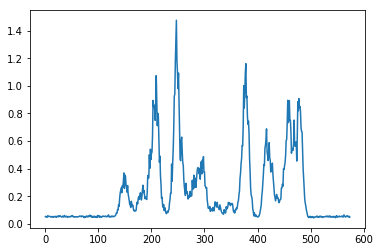

In [234]:
import matplotlib.pyplot as plt

plt.plot(fm1.log_odds)
plt.show()

## Work in Progress

In [ ]:
# This class controls the output, style and post processing of results
class Finder_Viewer():
    
    # draws exactly five patches and outputs to screen
    def draw_patches(rgb_color_list,save_to_file=False,file_info=None):
    
        file_loc, metadata, filename = file_info
        fig = plt.figure()
        ax = fig.add_subplot(111)     

        rect1 = matplotlib.patches.Rectangle((0,  0), 100, 100, color=rgb_color_list[0])
        rect2 = matplotlib.patches.Rectangle((150, 0), 100, 100, color=rgb_color_list[1])
        rect3 = matplotlib.patches.Rectangle((300, 0), 100, 100, color=rgb_color_list[2])
        rect4 = matplotlib.patches.Rectangle((0,-150), 100, 100, color=rgb_color_list[3])
        rect5 = matplotlib.patches.Rectangle((150,-150), 100, 100, color=rgb_color_list[4])
    
        ax.add_patch(rect1)
        ax.add_patch(rect2)
        ax.add_patch(rect3)
        ax.add_patch(rect4)
        ax.add_patch(rect5)
    
        plt.xlim([-50, 450])
        plt.ylim([-200, 150])
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            left='off',
            labelbottom='off',
            labelleft='off') # labels along the bottom edge are off
    
        if (save_to_file):
            pylab.savefig(file_name)
        else:
            plt.show()      
    

# EM Procedure to Find Trains and Colors

In [188]:
def train_finder_init(frame_list):

    l=len(frame_list)
    third = int(l/3)
    last = l 
    track_list =frame_list[0:third]
    background_list = frame_list[third:last]
    
    return train_list, background_list

def train_sampler(train_list, background_list, sample=10000):
    r, c, p = frame_list[0].shape
    background_sample=random_pixel_sample(train_list,sample,c,0,r)
    train_sample=random_pixel_sample(background_list,sample,c,0,r)
    t = len(train_list)
    b = len(background_list)
    
    train_prior = t/(t+b)
    background_prior = b/(b+t)
    priors = (train_prior, background_prior)
    
    return train_sample, background_sample, priors

def train_finder_gmm(train_sample,background_sample,n=5):

    background_gmm = GaussianMixture(n_components=n,covariance_type='full').fit(background_sample)
    background_colors = lab2rgb(background_gmm.means_)
    train_gmm = GaussianMixture(n_components=n,covariance_type='full').fit(train_sample)
    train_colors = lab2rgb(train_gmm.means_)    
    colors = (train_colors,background_colors)
    models = (train_gmm, background_gmm)
    
    return colors, models

def classify_frames(models,priors,frame_list):
    
    (train_gmm, background_gmm) = models
    (train_prior,background_prior) = priors
    x = len(frame_list)
    r, c, p = frame_list[0].shape

    track=[0]*x
    background=[0]*x
    log_odds = [0]*x
    classifier = [0]*x
    
    for i in range(x):
        aframe = [frame_list[i]]
        px_samples = random_pixel_sample(aframe,1000,c,0,r)
        z = train_gmm.score(px_samples)
        a = background_gmm.score(px_samples)

        track=z-math.log(train_prior)+(a+z)/2
        train=a-math.log(background_prior)+(a+z)/2
        # this returns a log-odds classifier
        # value > 1 more likely to be a train
        log_odds[i]=np.exp(track-train)
        classifier[i]=[log_odds[i],i]
        
    return classifier, log_odds

def make_train_labels():
    train_labels = {}
    
    for i in range(x):
        val = model_means[i][0]

        if (val > 1):
            train_labels[i]=True
        else:
            train_labels[i]=False
            
    return train_labels

def frame_classifier(frame_type,frame_labels):
    conv_list = []
    for i in range(len(frame_type)):
        label = frame_type[i]
        conv = train_labels[label]
        conv_list.append(conv)
        
    return conv_list

        
def make_breaks(conv_list):
    
    n = len(conv_list)
    break_count = 0
    break_list = []
    
    for i in range(n):
        new_type = conv_list[i]
        if (i==0):
            break_start = 0
            break_type = new_type
        if (break_type == new_type):
            next
        else:
            d = break_end-break_start
            break_end = i-1
            break_list.append((break_start,break_end,break_type))
            break_start = i
            break_type = conv_list[i]

        if (i==n-1):
            break_end = n
            break_list.append((break_start,break_end,break_type))

    return break_list   

def make_samples(train_list,break_list):
    train_list = []
    background_list = []
    for i in len(break_list):
        abreak = break_list[i]
        (start,end,break_type) = abreak
        if (break_type):
            train_list += train_list[start:end]
        else:
            background_list += train_list[start:end]
    return train_list, background_list 

def new_samples(train_list,classifier,n=3):
    
    frame_gmm = GaussianMixture(n_components=n,covariance_type='diag').fit(classifier)  
    model_means = frame_gmm.means_
    frame_type = frame_gmm.predict(classifier)
    train_labels = make_train_labels(model_means)
    conv_list = frame_classifier(frame_type,frame_type)
    breaks = make_breaks(conv_list)
    train_list,background_list = make_samples(train_list,break_list)
    
    return train_list, background_list, breaks



# Initialize the Object for Experimentation

In [243]:
# this finds the train with only a rough initialization and few iterations!
def train_finder(init=3,frame_list):
                 
    # step 0 initialize, specify the frames to sample
    train_list, background_list = train_finder_init(frame_list)
                 
    for i in range(init):
        # step E1 sample pixels from frames
        train_sample, track_sample, priors = train_sampler(train_list,background_list)
        # step E2 perform the gmm          
        (colors, models) = train_finder_gmm(train_sample,track_sample)
        # step M1 classify the frames
        classifier, log_odds = classify_frames(models,priors)
        # step M2 collect new samples 
        train_list, background_list, breaks = new_samples(train_list,classifier)
    
    output_metadata(colors,breaks,models,dir_loc)
    # step 3 -- output metadata, including patches, breaks and models  

SyntaxError: non-default argument follows default argument (<ipython-input-243-a4b7c3bf53b4>, line 2)

In [2]:
directory = "MVI_7478/image_list.json"
comp = Compressor(input_file=directory,output_file='',cex=0.25)


ACCELEROMETER, Get Frame Names, MVI_7478/image_list.json
575
ACCELEROMETER, Get Frame List,0
ACCELEROMETER, Get Frame List,100
ACCELEROMETER, Get Frame List,200
ACCELEROMETER, Get Frame List,300
ACCELEROMETER, Get Frame List,400
ACCELEROMETER, Get Frame List,500
ACCELEROMETER, Init 575


In [76]:
def return_tuple():
    a = (1,2)
    return a

print(return_tuple())
(c,d)=return_tuple()
print(c)
print(d)

(1, 2)
1
2


# Sort the Pixels into Tracks and Non-Tracks

## First Round (Initialization)

Initialize the model with first third as tracks, and next two-thirds as trains. 

In [244]:
frame_list = lab_list
print(len(frame_list))
r, c, p = frame_list[0].shape
print(r,c)
third = int(575*.333)
last = 575 
track_list = frame_list[0:third]
train_list = frame_list[third:last]

1150
1080 1920


In [245]:
frame_list = lab_list
r, c, p = frame_list[0].shape
print(r,c)
track_sample=random_pixel_sample(track_list,10000,c,0,1080)
train_sample=random_pixel_sample(train_list,10000,c,0,1080)


1080 1920


In [246]:
print(track_sample)

[array([243, 120, 120], dtype=uint8), array([235, 130, 142], dtype=uint8), array([242, 121, 120], dtype=uint8), array([242, 121, 120], dtype=uint8), array([194, 156, 167], dtype=uint8), array([253, 126, 127], dtype=uint8), array([241, 129, 146], dtype=uint8), array([ 27, 133, 130], dtype=uint8), array([201, 127, 136], dtype=uint8), array([242, 121, 120], dtype=uint8), array([216, 133, 148], dtype=uint8), array([252, 124, 126], dtype=uint8), array([250, 125, 125], dtype=uint8), array([250, 126, 125], dtype=uint8), array([251, 126, 126], dtype=uint8), array([238, 130, 143], dtype=uint8), array([176, 129, 138], dtype=uint8), array([123, 132, 131], dtype=uint8), array([249, 122, 124], dtype=uint8), array([183, 135, 146], dtype=uint8), array([251, 127, 136], dtype=uint8), array([163, 141, 159], dtype=uint8), array([245, 121, 122], dtype=uint8), array([175, 120, 109], dtype=uint8), array([246, 122, 122], dtype=uint8), array([198, 128, 149], dtype=uint8), array([254, 127, 127], dtype=uint8), 

In [247]:
from sklearn.mixture import GaussianMixture

track_gmm = GaussianMixture(n_components=5,covariance_type='full').fit(track_sample)
track_colors = lab2rgb(track_gmm.means_)
train_gmm = GaussianMixture(n_components=5,covariance_type='full').fit(train_sample)
train_colors = lab2rgb(train_gmm.means_)


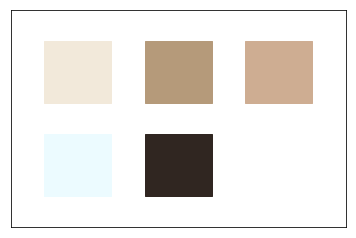

In [255]:
import matplotlib

metadata = "Metadata/"
file_loc = "C:/Users/LocalAdmin/Documents/MVI_7478/"
file_name = "background_patches.png"

file_info = (file_loc,metadata,file_name)

draw_patches(track_colors,save_to_file=False,file_info=file_info)

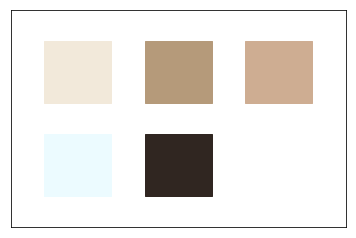

In [256]:
draw_patches(track_colors,save_to_file=False,file_info=file_info)

In [264]:
import math

frame_list = lab_list
x = len(frame_list)
no_frames = x
r, c, p = frame_list[0].shape

track=[0]*x
train=[0]*x
classifier = [0]*x

for i in range(x):
    aframe = [frame_list[i]]
    px_samples = random_pixel_sample(aframe,100,c,0,r)
    z=track_gmm.score(px_samples)
    a= train_gmm.score(px_samples)

    track[i]=z-math.log(0.333)
    train[i]=a-math.log(0.6666)
    classifier[i]=np.exp(-z+a-(a+z)/2)

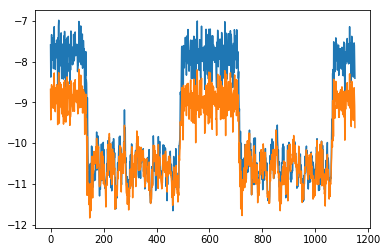

In [265]:

plt.plot(track)
plt.plot(train)
plt.show()

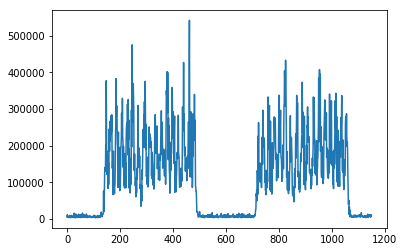

NameError: name 'find_train_start' is not defined

In [266]:
plt.plot(classifier)
plt.show()
start, end = find_train_start(classifier)
print("The train starts at frame "+str(start))
print("The train ends  at frame "+str(end))

In [ ]:
# THere are sixteen humps in the train signal, and sixteen wagons. This is caused by peaks/troughs of traininess. 

## Second Iteration

In [59]:
frame_list = comp.lab_list
print(len(frame_list))
r, c, p = frame_list[0].shape
print(r,c)
third = int(575*.333)
last = 575 
track_list = frame_list[0:135]+frame_list[494:575]
train_list = frame_list[136:493]

575
1080 1920


In [60]:
frame_list = comp.lab_list
r, c, p = frame_list[0].shape
print(r,c)
track_sample=random_pixel_sample(track_list,10000,c,0,1080)
train_sample=random_pixel_sample(train_list,10000,c,0,1080)


1080 1920


In [61]:
from sklearn.mixture import GaussianMixture

track_gmm = GaussianMixture(n_components=5,covariance_type='full').fit(track_sample)
track_colors = lab2rgb(track_gmm.means_)
train_gmm = GaussianMixture(n_components=5,covariance_type='full').fit(train_sample)
train_colors = lab2rgb(train_gmm.means_)


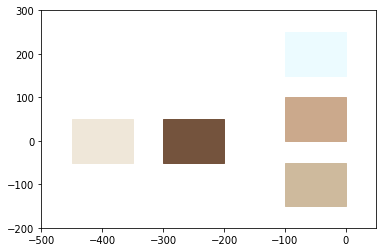

In [62]:
draw_patches(track_colors)

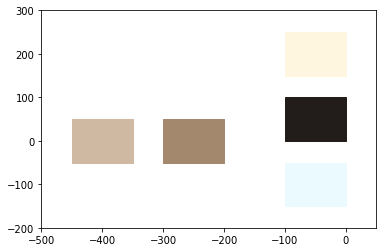

In [63]:
draw_patches(train_colors)

In [70]:
import math

frame_list = comp.lab_list
x = len(frame_list)
no_frames = comp.no_frames
r, c, p = frame_list[0].shape

track=[0]*x
train=[0]*x
classifier = [0]*x
prior1 = len(train_list)
prior2 = len(track_list)
for i in range(x):
    aframe = [frame_list[i]]
    px_samples = random_pixel_sample(aframe,5000,c,0,r)
    z=track_gmm.score(px_samples)
    a= train_gmm.score(px_samples)

    track[i]=z-math.log(prior2)
    train[i]=a-math.log(prior1)
    classifier[i]=np.exp(-z+y)/(np.exp(-z+y)+1)

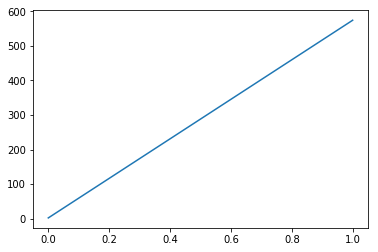

The train starts at frame 1
The train ends  at frame 2


In [91]:
plt.plot(classifier)
plt.show()
start, end = find_train_start(classifier)
print("The train starts at frame "+str(start))
print("The train ends  at frame "+str(end))

In [108]:
models = (train_gmm,track_gmm)
priors = (0.333,0.666)
classifier, odds =classify_frames(models,priors,frame_list)

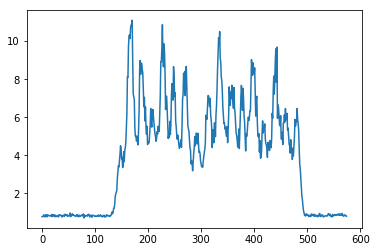

In [109]:
plt.plot(odds)
plt.show()

In [136]:
frame_gmm = GaussianMixture(n_components=3,covariance_type='diag').fit(classifier)

In [140]:
model_means = frame_gmm.means_
print(model_means)

[[   0.85539835  534.01569235]
 [   0.83659974   66.06374571]
 [   5.80760487  313.06446996]]


In [170]:
x = len(model_means)
train_labels = {}
for i in range(x):
    val = model_means[i][0]

    if (val > 1):
        train_labels[i]=True
    else:
        train_labels[i]=False
print(train_labels)

{0: False, 1: False, 2: True}


In [171]:
frame_type = frame_gmm.predict(classifier)

In [172]:
print(frame_type)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

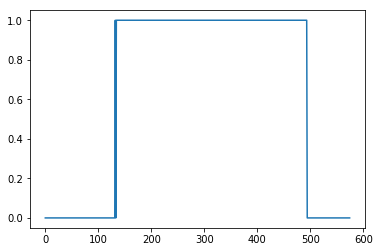

In [173]:
conv_list = []
for i in range(len(frame_type)):
    label = frame_type[i]
    conv = train_labels[label]
    conv_list.append(conv)
plt.plot(conv_list)
plt.show()

In [187]:
# how many breaks?
# where do they start and end?
# what type are they?

def make_breaks(conv_list):
    
    n = len(conv_list)
    break_count = 0
    break_list = []
    
    for i in range(n):
        new_type = conv_list[i]
        if (i==0):
            break_start = 0
            break_type = new_type
        if (break_type == new_type):
            next
        else:
            d = break_end-break_start
            break_end = i-1
            break_list.append((break_start,break_end,break_type))
            break_start = i
            break_type = conv_list[i]

        if (i==n-1):
            break_end = n
            break_list.append((break_start,break_end,break_type))

    return break_list
    

Beginning the Break 0
Ending the Break 132
Starting the Break 132
New Break Type is True
 
Ending the Break 133
Starting the Break 133
New Break Type is False
 
Ending the Break 134
Starting the Break 134
New Break Type is True
 
Ending the Break 494
Starting the Break 494
New Break Type is False
 
Ending the Break 574
[(0, 131, False), (132, 132, True), (133, 133, False), (134, 493, True), (494, 575, False)]


# Older Work

In [37]:
frame_list = comp.lab_list
no_frames = comp.no_frames
r, c, p = frame_list[0].shape
classifier = ['']*no_frames
for i in range(r):
    px_samples = random_pixel_sample(frame_list,100,c,i,i)

    y=train_gmm.score(px_samples)
    z=track_gmm.score(px_samples)
    classifier[i]=np.exp(-z+y)

IndexError: list assignment index out of range

In [ ]:
non_track_sample=random_pixel_sample(frame_list,10000,c,0,650)
sky_sample=random_pixel_sample(frame_list,10000,c,0,115)
frame_sample=random_pixel_sample(frame_list,10000,c,115,875)

In [215]:
from sklearn.mixture import GaussianMixture

track_gmm = GaussianMixture(n_components=5,covariance_type='full').fit(track_sample)
track_colors = lab2rgb(track_gmm.means_)
non_track_gmm = GaussianMixture(n_components=5,covariance_type='full').fit(non_track_sample)
non_track_colors = lab2rgb(non_track_gmm.means_)

sky_gmm = GaussianMixture(n_components=5,covariance_type='full').fit(sky_sample)
sky_colors = lab2rgb(sky_gmm.means_)

frame_gmm =  GaussianMixture(n_components=5,covariance_type='full').fit(frame_sample)
frame_colors  = lab2rgb(frame_gmm.means_)

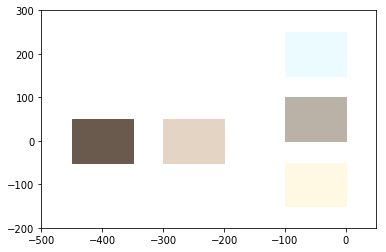

In [217]:
draw_patches(non_track_colors)

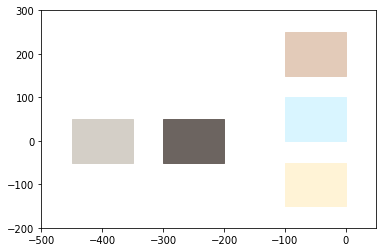

In [186]:
draw_patches(sky_colors)

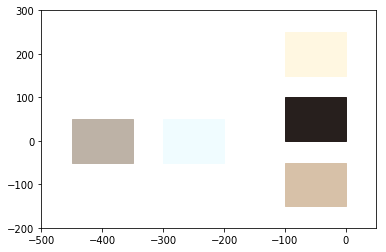

In [187]:
draw_patches(frame_colors)

In [16]:

print("The sampled colors are")
print(track_gmm.means_)
print()
print("The sampled covariances are")
print(frame_gmm.covariances_)
print()
# this found three colors -- stone, sky and shadow

The sampled colors are
[[ 242.01275032  125.13726162  122.34624648]
 [ 213.45035654  129.50792275  133.34886679]
 [ 241.20281129  120.8878031   119.69205441]
 [ 181.89830421  134.07619794  139.82601743]
 [ 122.90277149  128.93031674  132.34192258]]

The sampled covariances are
[[[  4.42355152e+02   1.57739236e+01   4.34477343e+01]
  [  1.57739236e+01   9.08939774e+00   4.75179239e+00]
  [  4.34477343e+01   4.75179239e+00   1.37538953e+01]]

 [[  4.48895333e+01  -5.24467125e+00  -4.94562057e+01]
  [ -5.24467125e+00   3.71119478e+00  -2.04156129e+00]
  [ -4.94562057e+01  -2.04156129e+00   8.42492929e+01]]

 [[  3.29982025e+03  -2.41549087e+02   1.32483907e+02]
  [ -2.41549087e+02   1.06025115e+02   3.48023525e+01]
  [  1.32483907e+02   3.48023525e+01   2.48440234e+02]]

 [[  7.89727901e+02  -5.73073663e+01  -7.52753479e+01]
  [ -5.73073663e+01   3.23684372e+01   5.52851890e+01]
  [ -7.52753479e+01   5.52851890e+01   1.26067251e+02]]

 [[  7.22522996e+00   4.79104012e+00   4.45343007e+00]

# Potential Cuts

Conclusions: The algorithm can tell the difference between the sky and the (background+tracks). It can also easily tell the difference between train frames and non-train frames. 

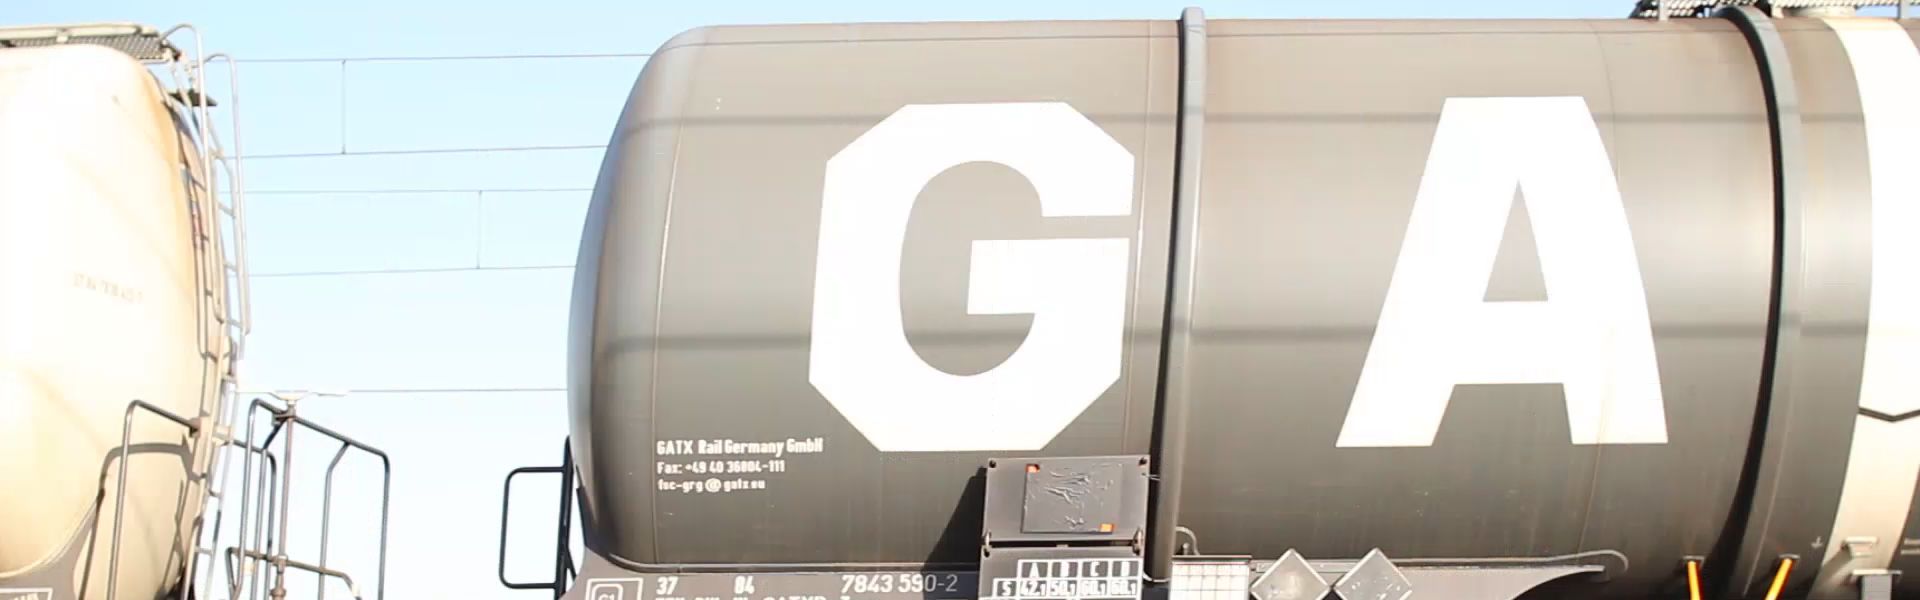

In [226]:
from PIL import Image
bgr_frame = comp.frame_list
snip0 = bgr_frame[200][0:600, :, :]
snip1=cv2.cvtColor(snip0,cv2.COLOR_BGR2RGB)
img_snip1 = Image.fromarray(snip1,'RGB')
display(img_snip1)

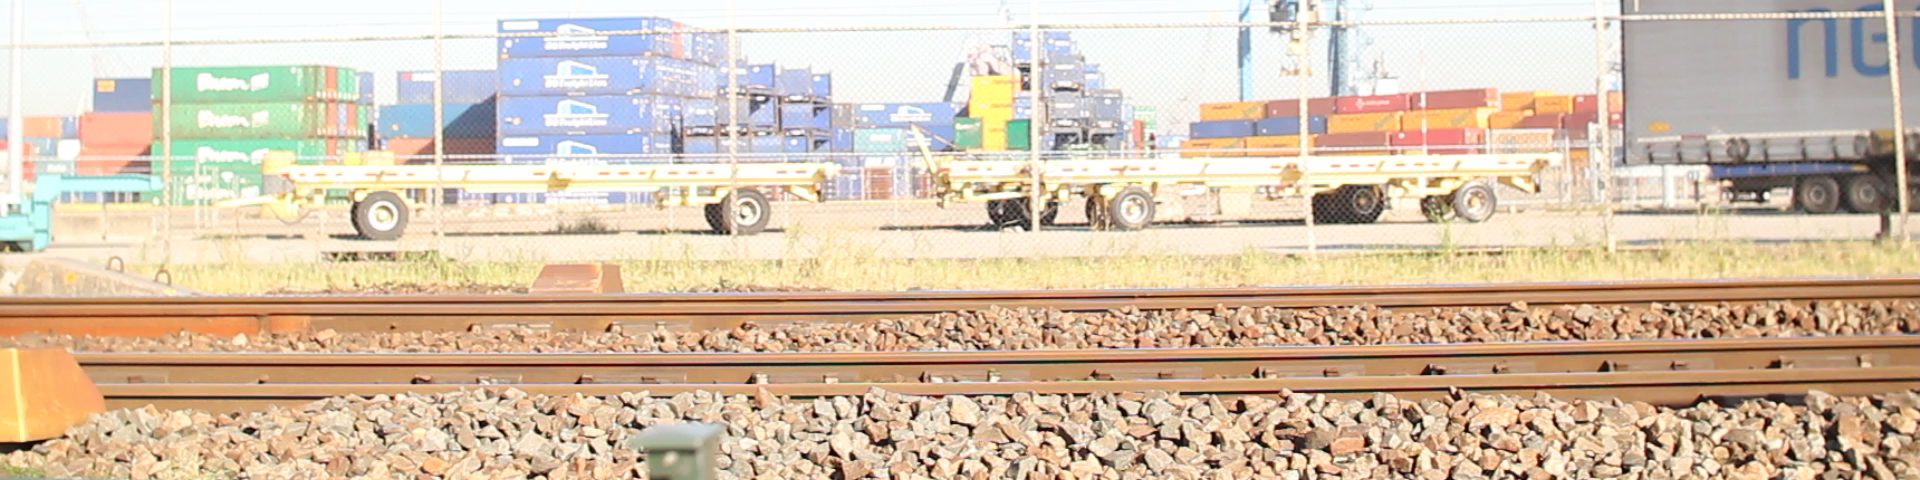

In [228]:
from PIL import Image
bgr_frame = comp.frame_list
snip0 = bgr_frame[0][600:1080, :, :]
snip1=cv2.cvtColor(snip0,cv2.COLOR_BGR2RGB)
img_snip1 = Image.fromarray(snip1,'RGB')
display(img_snip1)

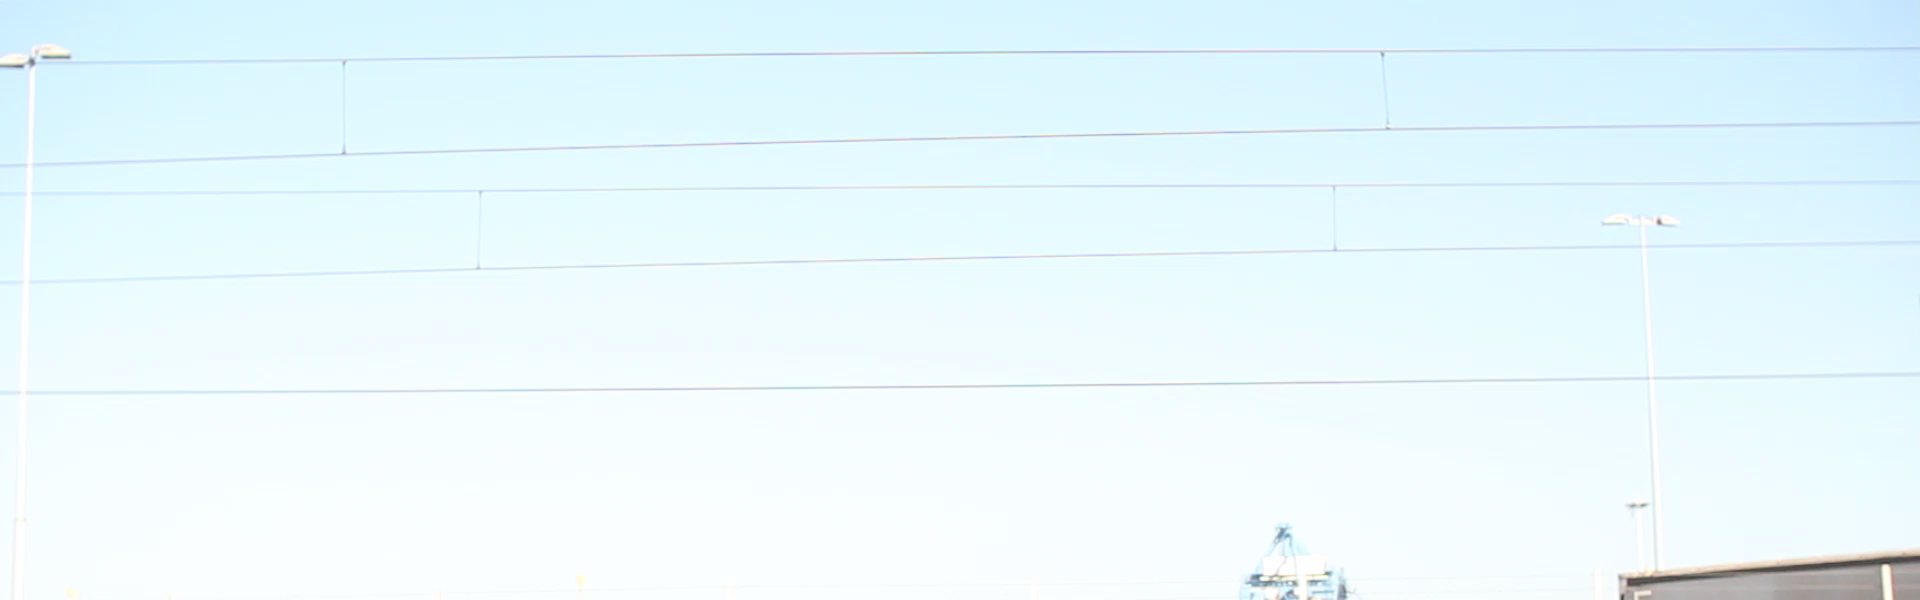

In [229]:
from PIL import Image
bgr_frame = comp.frame_list
snip0 = bgr_frame[0][0:600, :, :]
snip1=cv2.cvtColor(snip0,cv2.COLOR_BGR2RGB)
img_snip1 = Image.fromarray(snip1,'RGB')
display(img_snip1)

# Sort the Frames into Known Trains and Not Trains

In [449]:
print(comp.lab_list[0].shape)
print(comp.shrink_list[0].shape)
print(comp.frame_list[0].shape)
print(comp.frame_columns)

(1080, 1920, 3)
(270, 480, 3)
(1080, 1920, 3)
1920


In [366]:
frame_list = comp.lab_list
end = frame_list[489:comp.no_frames]
begin = frame_list[0:136]
train = frame_list[137:488]
background = begin+end

test_train = frame_list[400:401]
test_background = frame_list[500:501]

r, c, p = frame_list[0].shape

background_samples = random_pixel_sample(background,10000,r,c)
train_samples = random_pixel_sample(train,10000,r,c)
test_train_samples = random_pixel_sample(test_train,10000,r,c)
test_background_samples = random_pixel_sample(test_background,10000,r,c)

In [411]:
# fit three -- sky, tracks, and background
background_gmm = GaussianMixture(n_components=5,covariance_type='full').fit(background_samples)
print("The sampled colors are")
print(background_gmm.means_)
print()
print("The sampled covariances are")
print(background_gmm.covariances_)
print()
# this found three colors -- stone, sky and shadow

The sampled colors are
[[ 233.99949078  128.433676    133.61371936]
 [ 191.88793516  131.30917034  148.02549614]
 [ 248.7989588   123.80756266  124.17024505]
 [ 184.06408557  136.01835631  146.15207728]
 [  91.52711244  137.41974406  143.46390107]]

The sampled covariances are
[[[  226.8994104    -27.04678528    30.51919838]
  [  -27.04678528    12.09617155    13.66617505]
  [   30.51919838    13.66617505   173.71724829]]

 [[ 1132.96221356  -168.04622681   208.55928693]
  [ -168.04622681   154.99851523    33.14900872]
  [  208.55928693    33.14900872   235.95503927]]

 [[   17.33332581     8.31671626    10.41917453]
  [    8.31671626     5.26152171     5.0970892 ]
  [   10.41917453     5.0970892      6.40668531]]

 [[  339.59983518   -14.93998374   -25.76502985]
  [  -14.93998374    32.81761206    62.85152734]
  [  -25.76502985    62.85152734   164.00144404]]

 [[ 1577.21156852    -2.96686833   164.65768468]
  [   -2.96686833    76.31533418    49.15851264]
  [  164.65768468    49.1585

In [412]:
# fit three to enable model comparison  -- wagon, shadows, track
train_gmm = GaussianMixture(n_components=5,covariance_type='full').fit(train_samples)
print("The sampled colors are")
print(train_gmm.means_)
print()
print("The sampled covariances are")
print(train_gmm.covariances_)
print()
# this found three colors -- stone, sky and shadow

The sampled colors are
[[ 198.2230473   132.33483479  141.96606666]
 [ 247.94596942  123.95202973  123.71521023]
 [  30.30991613  130.52562347  131.07937792]
 [ 247.85940362  127.06514353  140.21216556]
 [ 155.35776202  133.99667071  145.36916897]]

The sampled covariances are
[[[  7.38293176e+02  -4.64233511e+01  -4.32976028e+01]
  [ -4.64233511e+01   2.67068082e+01   4.58946149e+01]
  [ -4.32976028e+01   4.58946149e+01   1.08860785e+02]]

 [[  3.13605658e+01   1.41136947e+01   1.88219233e+01]
  [  1.41136947e+01   8.00624627e+00   8.60092167e+00]
  [  1.88219233e+01   8.60092167e+00   1.14412816e+01]]

 [[  3.31534272e+02   1.07143728e+01   2.92623280e+01]
  [  1.07143728e+01   8.22563749e+00   2.75599927e+00]
  [  2.92623280e+01   2.75599927e+00   1.10482209e+01]]

 [[  3.47772168e+01  -2.18931014e+00  -4.58691138e+01]
  [ -2.18931014e+00   3.03919347e+00  -4.34949779e+00]
  [ -4.58691138e+01  -4.34949779e+00   8.11175083e+01]]

 [[  3.15380627e+03  -1.36827660e+02   2.73061828e+02]

In [413]:
x=background_gmm.score(test_background_samples)
y=train_gmm.score(test_background_samples)
print(x,y)
print(np.exp(x-y))
# background tests background 12 times likely as train with three colors
# background tests background 2 times likely as train with five colors

-8.93692009627 -9.8249683355
2.43038149592


In [414]:
x=background_gmm.score(test_train_samples)
y=train_gmm.score(test_train_samples)
print(x,y)
print(np.exp(-x+y))
# train tests train four times more likely as background with three colors
# train tests train five times more likely as background with five colors

-12.5670730324 -10.8635454376
5.4932913591


# Classify Each Row

In [224]:
import math

frame_list = comp.lab_list
no_frames = comp.no_frames
r, c, p = frame_list[0].shape

sky = [0]*r
frame=[0]*r
track=[0]*r
non_track=[0]*r

for i in range(r):
  
    px_samples = random_pixel_sample(frame_list,100,c,i,i)
    x=sky_gmm.score(px_samples)
    y=frame_gmm.score(px_samples)
    z=track_gmm.score(px_samples)
    a= non_track_gmm.score(px_samples)
    sky[i]=x-math.log(10/1080)
    frame[i]=y-math.log((1080-215)/1080)
    track[i]=z-math.log((1080-600)/1080)
    non_track[i]=a-math.log(600/1080)


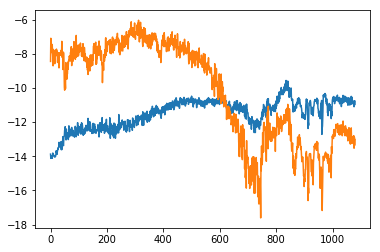

In [225]:
#plt.plot(sky)
#plt.plot(frame)
plt.plot(track)
plt.plot(non_track)
plt.show()

In [190]:
frame_list = comp.lab_list
no_frames = comp.no_frames
r, c, p = frame_list[0].shape
classifier = ['']*no_frames
for i in range(r):
    px_samples = random_pixel_sample(aframe,100,i,c)
    x=sky_gmm.score(px_samples)
    y=background_gmm.score(px_samples)
    z=track_gmm.score(px_samples)
    classifier[i]=np.exp(-x+y)

NameError: name 'aframe' is not defined

# Classify Each Frame

In [425]:
print(classifier[140])

0.816924210308


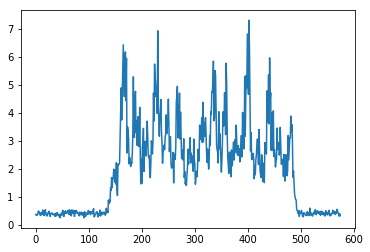

In [417]:
plt.plot(classifier)

In [443]:
stitch_array = None
new_array = frame_list[i]
first_train_frame = None
final_train_frame = None
for i in range(no_frames):
    if (i%50==0):
        print("Compressing Frame "+str(i))
        #print(new_array.shape)
    if (classifier[i] < 1):
        # elastic!
        next
    else:
        if not (first_train_frame):
            first_train_frame = i
            final_train_frame = i
        if (i > final_train_frame):
            final_train_frame = i

print(first_train_frame,final_train_frame)

        

Compressing Frame 0
Compressing Frame 50
Compressing Frame 100
Compressing Frame 150
Compressing Frame 200
Compressing Frame 250
Compressing Frame 300
Compressing Frame 350
Compressing Frame 400
Compressing Frame 450
Compressing Frame 500
Compressing Frame 550
141 488


In [474]:
collapse = int(comp.frame_columns*(1/13))
z = final_train_frame-first_train_frame
print(z)
snip = [None]*(z+1)
for i in range(first_train_frame,final_train_frame+1):
    # The smoothed snips are all 124,120
    j = i-first_train_frame

    snip[j] = frame_list[i][:, 0:collapse, :]
    if (i==final_train_frame):
        print("hit final frame!")
        snip[j]=frame_list[final_train_frame][:,:,:]
    if (i%50==0):
        print("working on frame "+str(i))

print("now concatenating")
full_image = np.concatenate(snip,axis=1) 
print("now color conversion")
conv= cv2.cvtColor(full_image, cv2.COLOR_LAB2RGB)
img_stitch = Image.fromarray(conv,'RGB')
print("now saving")
img_stitch.save('C:/Users/LocalAdmin/347_frame_train_small.png')



347
working on frame 150
working on frame 200
working on frame 250
working on frame 300
working on frame 350
working on frame 400
working on frame 450
hit final frame!
now concatenating
now color conversion
now saving


In [426]:
def stitch(pic,pic_add,elastic=0.97):
    # append
    row,col,pix=pic_add.shape
    collapse = int(col*elastic)
    new_array = np.concatenate((pic,pic_add[:,0:collapse,:]),axis=1)
    return new_array

# Collect Data for Scikit Learn KMeans

KeyboardInterrupt: 

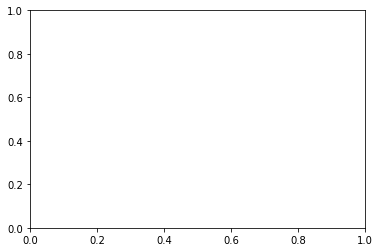

In [340]:
frame_list = comp.frame_list
n = comp.no_frames
rows = comp.frame_rows
cols = comp.frame_columns
data = []
L_list = []
C_list = []
a_list = []
b_list = []

for i in range(n):
    for j in range(1000):
        r=np.random.randint(rows)
        c=np.random.randint(cols)
        randcolor=frame_list[i][r,c,:]
        data.append(randcolor)
        
        L,a,b = randcolor
        L_list.append(L)
        if (L <128):
            C_list.append('blue')
        else:
            C_list.append('red')
        a_list.append(a)
        b_list.append(b)

plt.scatter(a_list,b_list,color=C_list)

In [ ]:
from sklearn.cluster import KMeans
import pandas as pd


kmeans = KMeans(n_clusters=2,random_state=0).fit(data)
print(kmeans.cluster_centers_)
x1=kmeans.predict(data[0:575])
x2 = kmeans.predict(data[575:575*2])
x3 = kmeans.predict(data[575*2:575*3])

x = x1+x2+x3

plt.plot(x1)
plt.axvline(x=129,color='red')
plt.axvline(x=496,color='red')

In [318]:
from sklearn.mixture import GaussianMixture
import pandas as pd
import itertools, time,math
from scipy import linalg
eps = 1e-100
now = time.time()
gmm = GaussianMixture(n_components=2,covariance_type='full').fit(data)
print("The sampled colors are")
print(gmm.means_)
print()
print("The sampled covariances are")
print(gmm.covariances_)
print()
print("These are the predictions")
z=gmm.predict(data)
print(z[0:100])
print("These are the likelihoods")
az=gmm.predict_proba(data[0:100])
az = np.array(az*(1-eps)+eps)
print(az)
az0 = np.sum(np.log(az[0]))/100
az1 = np.sum(np.log(az[1]))/100
print(az0,az1)
print(math.exp(az0),math.exp(az1))
then = time.time()
print("This took "+str(then-now)+" seconds")

The sampled colors are
[[ 159.76355987  181.08812603  198.86112678]
 [ 254.9281289   250.27980377  234.66383103]]

The sampled covariances are
[[[  4.00379955e+03   3.78700905e+03   3.23829749e+03]
  [  3.78700905e+03   3.98767243e+03   3.69808045e+03]
  [  3.23829749e+03   3.69808045e+03   3.83919955e+03]]

 [[  6.67066468e-02   4.10713213e-02   1.41874492e-01]
  [  4.10713213e-02   1.44142072e+01   4.56220841e+01]
  [  1.41874492e-01   4.56220841e+01   1.69221029e+02]]]

These are the predictions
[1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0
 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1
 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 1 1 1 0 0 0 1 1]
These are the likelihoods
[[  6.33363128e-004   9.99366637e-001]
 [  1.00000000e+000   1.00000000e-100]
 [  1.00000000e+000   1.00000000e-100]
 [  2.33686305e-001   7.66313695e-001]
 [  1.00000000e+000   1.00000000e-100]
 [  1.00000000e+000   1.00000000e-100]
 [  1.00000000e+000   1.00000000

[[  1.00000000e-100   1.00000000e+000]
 [  9.99834173e-001   1.65826812e-004]
 [  9.99638353e-001   3.61646513e-004]
 [  1.00000000e-100   1.00000000e+000]
 [  9.99867052e-001   1.32948462e-004]
 [  9.99696087e-001   3.03913130e-004]
 [  1.00000000e-100   1.00000000e+000]
 [  9.99638353e-001   3.61646513e-004]
 [  9.99836703e-001   1.63296817e-004]
 [  8.32552675e-001   1.67447325e-001]
 [  1.00000000e-100   1.00000000e+000]
 [  9.99728624e-001   2.71376350e-004]
 [  9.99728624e-001   2.71376350e-004]
 [  9.99874586e-001   1.25414153e-004]
 [  1.00000000e-100   1.00000000e+000]
 [  9.99731869e-001   2.68131233e-004]
 [  1.00000000e-100   1.00000000e+000]
 [  9.99598093e-001   4.01907472e-004]
 [  1.00000000e-100   1.00000000e+000]
 [  9.99867052e-001   1.32948462e-004]
 [  9.99836703e-001   1.63296817e-004]
 [  1.00000000e-100   1.00000000e+000]
 [  9.99817083e-001   1.82916540e-004]
 [  9.99829964e-001   1.70035765e-004]
 [  6.82432544e-077   1.00000000e+000]
 [  9.99682601e-001   3.1

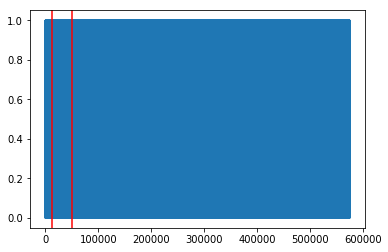

In [317]:
print(az)
plt.plot(z)
plt.axvline(x=129*100,color='red')
plt.axvline(x=496*100,color='red')
print(len(z))
print(sum(z)/len(z))

# Assign the Frames to a Class

In [277]:

assign_list = ['']*n

for i in range(n):
    k = random.random()
    if ( k < 0.5):
        val = 0
    else:
        val = 1
        
    assign_list[i]=val
    

# Manually Iterate K-Means

In [278]:
import numpy as np

my_frames = comp.shrink_list
color_list_background = [0]*3
ave_color0= [0]*3
ave_color1 = [0]*3
color_list_train = [0]*3
row,col,pix = my_frames[0].shape
#total_el= n*row*col
total_el0 = 0
total_el1 = 0
for i in range(n):  
    if (i%50==0):
        print("working "+str(i))
    for r in range(row):
        for c in range(col):
            rnd = random.random()
            if (rnd < 0.003):
                if (assign_list[i]==0):
                    total_el0+=1
                    color_list_background[0]+=np.float(my_frames[i][r,c,0])
                    color_list_background[1]+=np.float(my_frames[i][r,c,1])
                    color_list_background[2]+=np.float(my_frames[i][r,c,2])
                else:
                    total_el1 +=1
                    color_list_train[0]+=np.float(my_frames[i][r,c,0])
                    color_list_train[1]+=np.float(my_frames[i][r,c,1])
                    color_list_train[2]+=np.float(my_frames[i][r,c,2])                    

ave_color0 = np.array([[color_list_background]])/total_el0
print(ave_color0.astype(np.uint8))
ave_color1 = np.array([[color_list_train]])/total_el1
print(ave_color1.astype(np.uint8))
#conv0 = cv2.cvtColor(ave_color0, cv2.COLOR_LAB2RGB)
#conv1 = cv2.cvtColor(ave_color1, cv2.COLOR_LAB2RGB)
#print(conv0)
#print(conv1)

working 0
working 50
working 100


KeyboardInterrupt: 

# Color Experiments

In [382]:
from skimage import io, color

rgb_color = np.array([[[255,255,255]]],dtype=np.uint8)
lab_color1 = np.array([[[247*100/255,127-128,136-128]]])
lab_color2 = np.array([[[54*100/255,132-128,134-128]]])
lab_color3 = np.array([[[192*100/255,133-128,144-128]]])

lab_conv = color.rgb2lab(rgb_color)
rgb_conv1 = color.lab2rgb(lab_color1)
rgb_conv2 = color.lab2rgb(lab_color2)
rgb_conv3 = color.lab2rgb(lab_color3)

print(lab_color1)
print(lab_conv)
print(rgb_conv1)
print(rgb_conv2)

x1, y1, z1 = rgb_conv1[0,0,0:3]
x2, y2, z2 = rgb_conv2[0,0,0:3]
x3, y3, z3 = rgb_conv3[0,0,0:3]


print(x1,y1,z1)
print(x2,y2,z2)
print(x3,y3,z3)

[[[ 96.8627451  -1.          8.       ]]]
[[[  1.00000000e+02  -2.45493786e-03   4.65342115e-03]]]
[[[ 0.98344411  0.96458484  0.90399454]]]
[[[ 0.23550319  0.19045724  0.16558817]]]
0.983444105441 0.964584838087 0.903994540214
0.235503191616 0.190457242213 0.165588174872
0.808428560153 0.711176342067 0.613208484065


C:\Users\LocalAdmin\Anaconda3\lib\site-packages\matplotlib\figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


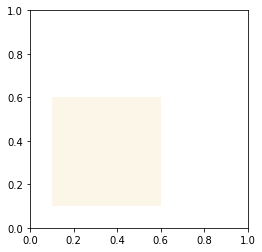

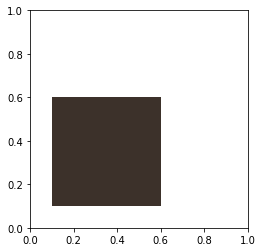

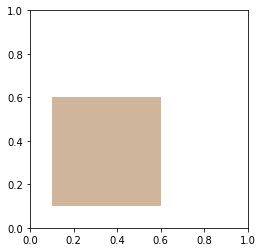

In [383]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.add_patch(
    patches.Rectangle(
        (0.1, 0.1),   # (x,y)
        0.5,          # width
        0.5,          # height
        facecolor=[x1,y1,z1]
    )
)
fig1.show()
fig2 = plt.figure()
ax2 = fig2.add_subplot(111, aspect='equal')
ax2.add_patch(
    patches.Rectangle(
        (0.1, 0.1),   # (x,y)
        0.5,          # width
        0.5,          # height
        facecolor=[x2,y2,z2]
    )
)
fig2.show()
 
fig3 = plt.figure()
ax3 = fig3.add_subplot(111, aspect='equal')
ax3.add_patch(
    patches.Rectangle(
        (0.1, 0.1),   # (x,y)
        0.5,          # width
        0.5,          # height
        facecolor=[x3,y3,z3]
    )
)
fig3.show()
